## Inverse Kinematics: FABRIK + Angle Limit

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from math import tau, pi, sin, cos

In [2]:
class Arm:
    def __init__(self, ax, ay, length, angle, minAngle=-pi/2, maxAngle=pi/2):
        self.ax = ax
        self.ay = ay
        self.length = length
        self.angle = convTheta(angle)
        self.bx = self.ax + self.length * cos(self.angle)
        self.by = self.ay + self.length * sin(self.angle)
        self.minAngle = convTheta(minAngle)
        self.maxAngle = convTheta(maxAngle)

    def backward(self, tx, ty):
        theta = np.arctan2(ty - self.ay, tx - self.ax)
        self.bx = tx
        self.by = ty
        self.ax = tx - self.length * cos(theta)
        self.ay = ty - self.length * sin(theta)
        self.angle = convTheta(theta)
        
    def forward(self, baseX, baseY):
        theta = np.arctan2(self.by - baseY, self.bx - baseX)
        self.ax = baseX
        self.ay = baseY
        self.bx = baseX + self.length * cos(theta)
        self.by = baseY + self.length * sin(theta)    
        self.angle = convTheta(theta)
        
    def backward2(self, tx, ty, prevTheta):
        theta = convTheta(np.arctan2(ty - self.ay, tx - self.ax) - prevTheta)
        if theta < self.minAngle:
            theta = self.minAngle
        elif theta > self.maxAngle:
            theta = self.maxAngle
        self.angle = convTheta(theta + prevTheta)
        self.bx = tx
        self.by = ty
        self.ax = self.bx - self.length * cos(self.angle)
        self.ay = self.by - self.length * sin(self.angle)
    
    def forward2(self, baseX, baseY, prevTheta):
        theta = convTheta(np.arctan2(self.by - baseY, self.bx - baseX) - prevTheta)
        if theta < self.minAngle:
            theta = self.minAngle
        elif theta > self.maxAngle:
            theta = self.maxAngle
        self.angle = convTheta(theta + prevTheta)
        self.ax = baseX
        self.ay = baseY
        self.bx = self.ax + self.length * cos(self.angle)
        self.by = self.ay + self.length * sin(self.angle)

def convTheta(theta):
    theta = theta % tau
    if theta > pi:
        theta = theta - tau
    return theta 

<IPython.core.display.Javascript object>


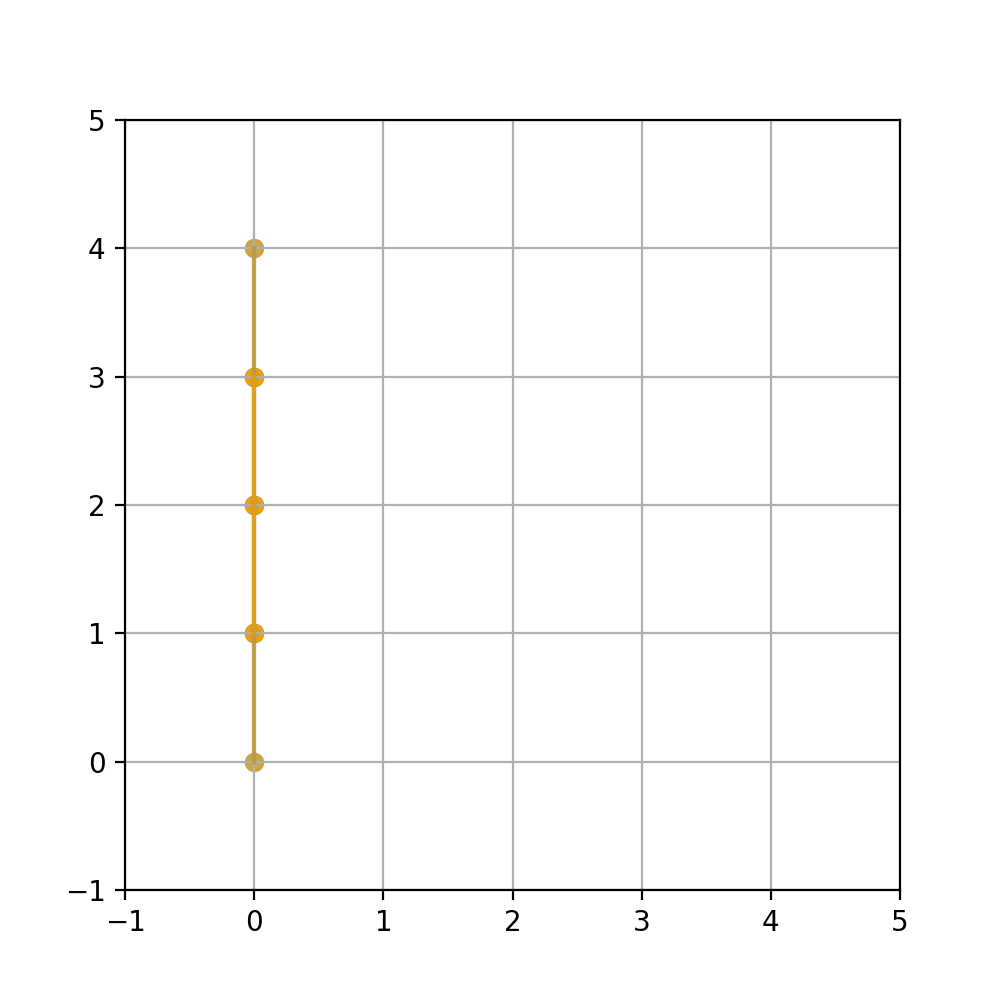

In [9]:
N  = 4 # the number of link
OX = 0 # offset x: Base coodinates
OY = 0 # offset y: Base coodinates

fab = []
X, Y = [], []
fabA = []
AX, AY = [], []
linkLength = 1
initTheta = np.radians(90)

for i in range(N):
    if i == 0:
        fab.append(Arm(OX, OY, linkLength, initTheta))
        fabA.append(Arm(OX, OY, linkLength, initTheta, 0, pi))
    else:
        fab.append(Arm(fab[i-1].bx, fab[i-1].by, linkLength, initTheta))
        fabA.append(Arm(fabA[i-1].bx, fabA[i-1].by, linkLength, initTheta, -pi/2, pi/2))

    X.append([fab[i].ax, fab[i].bx])
    Y.append([fab[i].ay, fab[i].by])
    AX.append([fabA[i].ax, fabA[i].bx])
    AY.append([fabA[i].ay, fabA[i].by])
        
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.axis([-1,N+1,-1,N+1])
ax.grid()
ax.plot(X, Y, color='tab:blue', alpha=0.6)
ax.scatter(X, Y, color='tab:blue', alpha=0.6)
ax.plot(AX, AY, color='orange', alpha=0.6)
ax.scatter(AX, AY, color='orange', alpha=0.6)

<IPython.core.display.Javascript object>


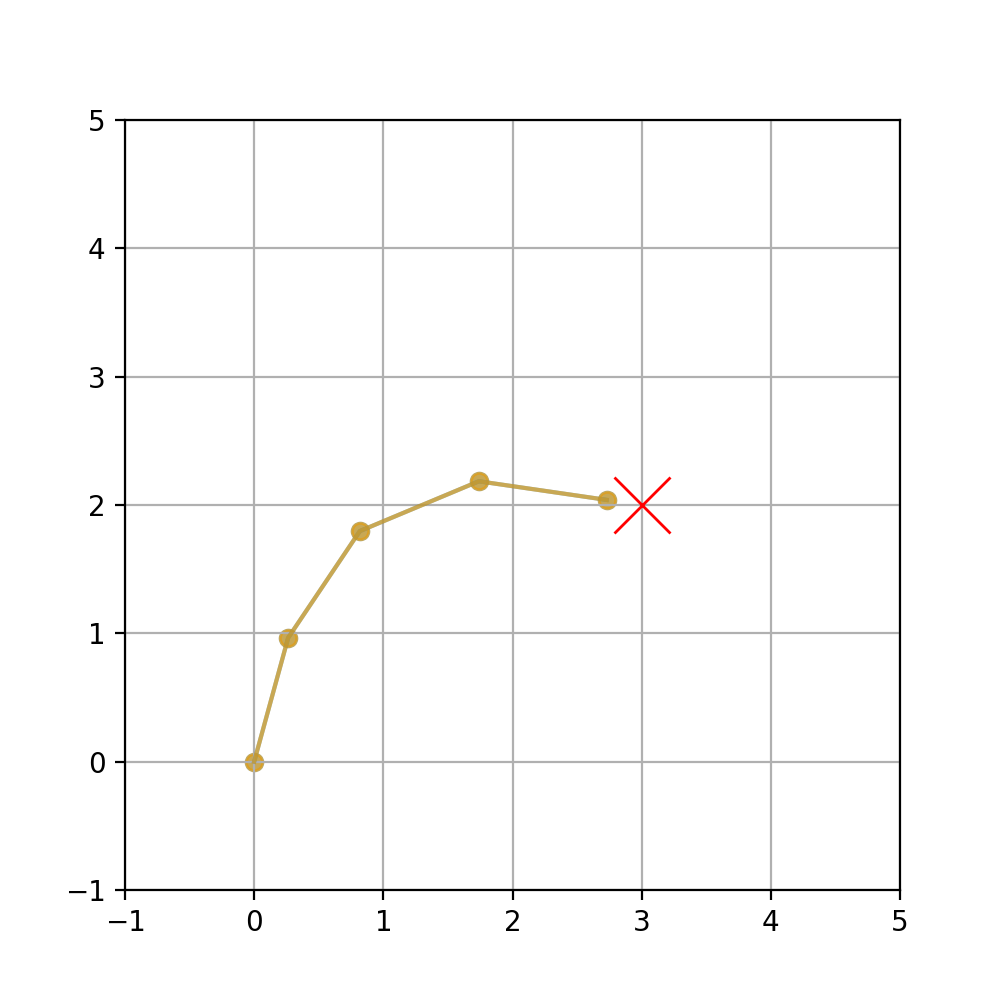

In [10]:
# FABRIK: Backward + Forward
def FABRIK(arm, tx, ty):
    for i in reversed(range(N)):
        arm[i].backward(tx, ty)
        tx = arm[i].ax
        ty = arm[i].ay
    
    baseX, baseY = OX, OY
    for i in range(N):
        arm[i].forward(baseX, baseY);
        baseX = arm[i].bx
        baseY = arm[i].by
        
    PX, PY = [], []
    for i in range(N):
        PX.append(arm[i].ax)
        PY.append(arm[i].ay)  
    PX.append(arm[N-1].bx)
    PY.append(arm[N-1].by)
    
    return PX, PY

# FABRIK + AngleLimit
def FABRIK2(arm, tx, ty):
    for i in reversed(range(N)):
        if i == N-1:
            arm[i].backward2(tx, ty, 0)
        else:
            arm[i].backward2(tx, ty, arm[i+1].angle)
        tx = arm[i].ax
        ty = arm[i].ay        
    
    baseX, baseY = OX, OY
    for i in range(N):
        if i == 0:
            arm[i].forward2(baseX, baseY, 0)
        else:
            arm[i].forward2(baseX, baseY, arm[i-1].angle)
        baseX = arm[i].bx
        baseY = arm[i].by
        
    PX, PY = [], []
    for i in range(N):
        PX.append(arm[i].ax)
        PY.append(arm[i].ay)  
    PX.append(arm[N-1].bx)
    PY.append(arm[N-1].by)
    
    return PX, PY

tx, ty = 3.0, 2.0
X, Y = FABRIK(fab, tx, ty)
AX, AY = FABRIK2(fabA, tx, ty)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.axis([-1,N+1,-1,N+1])
ax.grid()
ax.plot(X, Y, color='tab:blue', alpha=0.6)
ax.scatter(X, Y, color='tab:blue', alpha=0.6)
ax.plot(AX, AY, color='orange', alpha=0.6)
ax.scatter(AX, AY, color='orange', alpha=0.6)
ax.plot([tx],[ty], marker='x', ms=20, color='red')

<IPython.core.display.Javascript object>


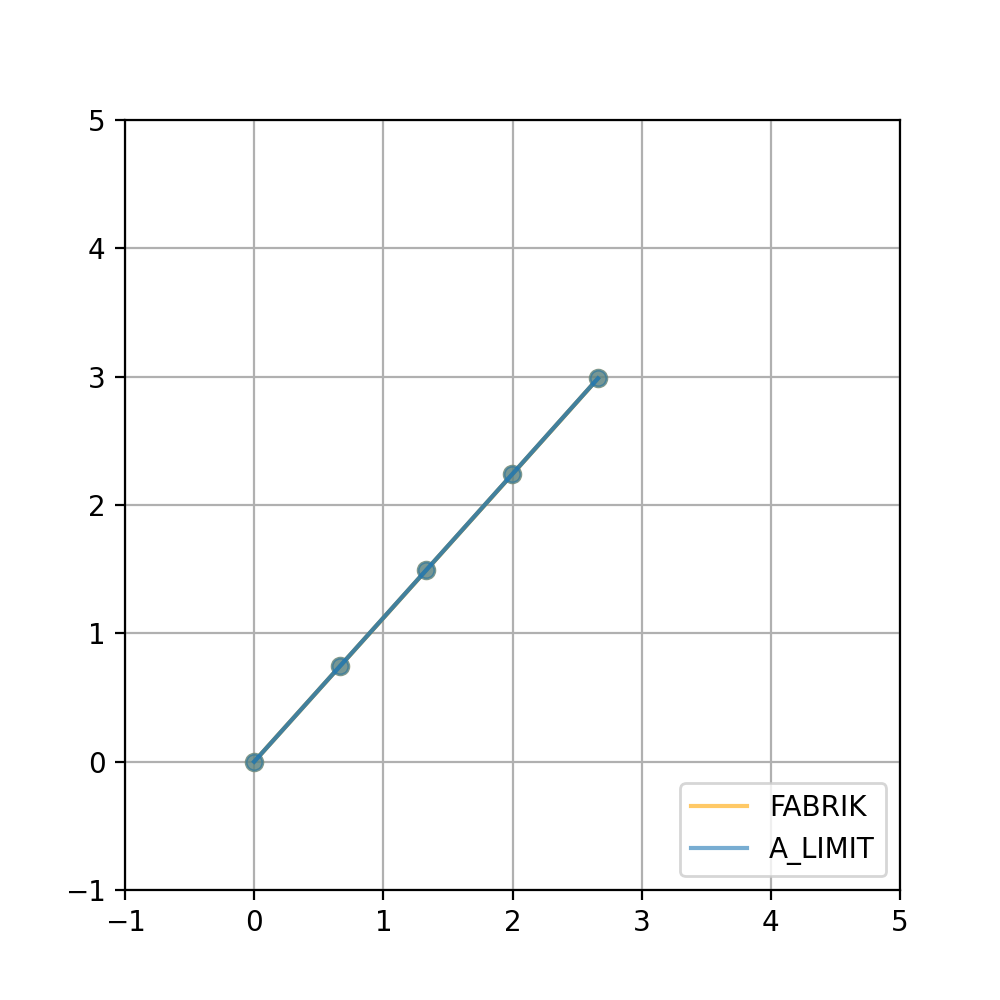

In [11]:
def motion(event):
    mx = event.xdata
    my = event.ydata
    Mouse.set_data(mx, my)
    
    FX, FY = FABRIK(fab, mx, my)
    FLine.set_data(FX, FY)
    FDot.set_data(FX, FY)
    
    AX, AY = FABRIK2(fabA, mx, my)
    ALine.set_data(AX, AY)
    ADot.set_data(AX, AY)
    
    plt.draw()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.axis([-1,N+1,-1,N+1])
ax.grid()

FLine, = ax.plot([],[], linestyle='-', color='orange', alpha=0.6, label='FABRIK')
FDot, = ax.plot([],[], marker='o', color='orange', alpha=0.6)
ALine, = ax.plot([],[], linestyle='-', color='tab:blue', alpha=0.6, label='A_LIMIT')
ADot, = ax.plot([],[], marker='o', color='tab:blue', alpha=0.6)

Mouse, = ax.plot([],[], marker='x', ms=20, color='red')
plt.connect('motion_notify_event', motion)
plt.legend(loc='lower right')
plt.show()